# Notes
- Re-running with higher weight decay to try and get more active units in the low-d regime. (didn't work)
- Re-running with same initialization on w_in and w_out as for other tasks. 

In [3]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4

/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4


In [4]:
from ParametricWMTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .75


In [5]:
def compute_var(variance,n):
    return np.sum(variance[n:])

# def compute_var_1(variance,n):
#     return np.sum(variance[n:])

def compute_p(k, null_k):
    return np.sum(null_k<k)/len(null_k)

2.154434690031882
6.812920690579608
6.812920690579608
10.0


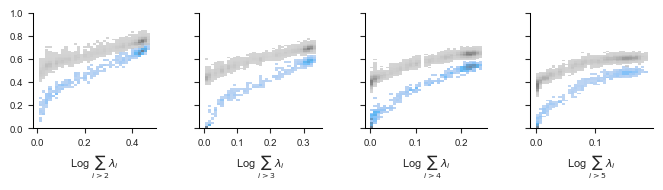

In [36]:
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(8,1.5))
gs = gridspec.GridSpec(1,4,wspace = .35)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Results_4'):
    f = os.path.join('Results_4', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.1]

original_df = original_df[original_df.activity_std<.05]
#original_df = original_df[original_df.n==100]

#original_df = original_df[original_df.lvar<=1]
#original_df = original_df[original_df.sigma_rec==1.0]
original_df = original_df[original_df.lr==.005]
#original_df = original_df[original_df.lambda_std==0.4]

#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(4):
    ax = axes[i]
    k = 3+i
    df = original_df.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    #df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim==k]
    print(df.lvar.max())
    #print(df.lvar.min())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec':row['sigma_rec'],
                         'weight_decay':row['weight_decay'],
                         'lr':row['lr'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
    #null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=.75,bins=(35,35))
    sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=.75,bins=(35,35),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    for lr in [.001,.005]:
        for sample in range(25):   
            #try:
            frac = .5
            sample_df = df[(df.weight_decay==weight_decay) & (df.lr==lr) ].sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values
    
            sample_null_df = null_df[(null_df.weight_decay==weight_decay) & (df.lr==lr)].sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values
    
            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)
    
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step': step,
                                     'k':k,
                                     'weight_decay':weight_decay,
                                     'lr':lr,
                                 'type': 1,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
                continue
        
    
            try:
                popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
                y_fit = f(x_values, *popt)
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step':step,
                                     'k':k,
                                     'weight_decay':weight_decay,
                                     'lr':lr,
                                 'type': 0,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
               continue
                  

# 
# fit_df = pd.DataFrame(fit_rows)
# for k in range(3):
#     ax = axes[k]
#     sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==4+k)], x= 'x', y='y',ax=ax,legend = False,lw=1,hue = 'lr',alpha = 1,errorbar=None)
#     sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==4+k)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=7,bottom=True)
    ax.yaxis.set_tick_params(labelsize=7,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(0,1)
    #ax.set_xlim(-10,-2)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=8)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=8)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=8)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=8)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

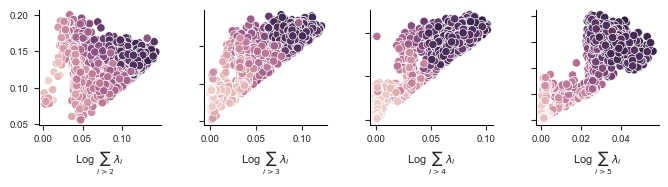

In [33]:
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(8,1.5))
gs = gridspec.GridSpec(1,4,wspace = .35)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Results_4'):
    f = os.path.join('Results_4', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.1]

original_df = original_df[original_df.activity_std<.05]
#original_df = original_df[original_df.n==100]

#original_df = original_df[original_df.lvar<=1]
#original_df = original_df[original_df.sigma_rec==1.0]
original_df = original_df[original_df.lr==.005]
#original_df = original_df[original_df.lambda_std==0.4]

#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(4):
    ax = axes[i]
    k = 3+i
    df = original_df.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['var_1'] = df.variance.apply(lambda x: x[k-1])
    df['var_2'] = df.variance.apply(lambda x: x[k])
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    #df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    #df = df[df.dim==k]
    #print(df.lvar.max())
    #print(df.lvar.min())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec':row['sigma_rec'],
                         'weight_decay':row['weight_decay'],
                         'lr':row['lr'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
    #null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.scatterplot(data=df, x='var_2', y='var_1',hue='k_inertia',ax=ax,legend=False,alpha=1)
    #sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=.75,bins=(35,35),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    for lr in [.001,.005]:
        for sample in range(25):   
            #try:
            frac = .5
            sample_df = df[(df.weight_decay==weight_decay) & (df.lr==lr) ].sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values
    
            sample_null_df = null_df[(null_df.weight_decay==weight_decay) & (df.lr==lr)].sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values
    
            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)
    
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step': step,
                                     'k':k,
                                     'weight_decay':weight_decay,
                                     'lr':lr,
                                 'type': 1,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
                continue
        
    
            try:
                popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
                y_fit = f(x_values, *popt)
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step':step,
                                     'k':k,
                                     'weight_decay':weight_decay,
                                     'lr':lr,
                                 'type': 0,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
               continue
                  

# 
# fit_df = pd.DataFrame(fit_rows)
# for k in range(3):
#     ax = axes[k]
#     sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==4+k)], x= 'x', y='y',ax=ax,legend = False,lw=1,hue = 'lr',alpha = 1,errorbar=None)
#     sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==4+k)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=7,bottom=True)
    ax.yaxis.set_tick_params(labelsize=7,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    #ax.set_ylim(0,1)
    #ax.set_xlim(-10,-2)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=8)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=8)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=8)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=8)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

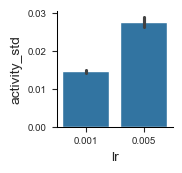

In [10]:
# lr and active neurons
df = original_df.copy()
df.activity_std = df.activity_std.astype(float)
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
k = 4
df = df[df.dim==k]
    
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.barplot(data = df[df['var']<-4],x = 'lr',y='activity_std',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')


In [5]:
df_list = []
for filename in os.listdir('Results_4'):
    f = os.path.join('Results_4', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.1]

original_df = original_df[original_df.n<.05]

array([0.008, 0.   , 0.004])

/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_18799/767462242.py:15: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.barplot(data = df[df['var']<0], x = 'lr',y='k_inertia',hue = 'weight_decay',ax=ax,legend=False,errwidth=.5)


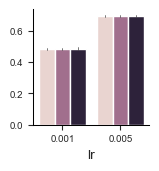

<Figure size 640x480 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))

df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
#df = df[df.k>=k]
df = df[df.dim==k]
df.activity_std = df.activity_std.astype(float)
plt.figure()
sns.barplot(data = df[df['var']<0], x = 'lr',y='k_inertia',hue = 'weight_decay',ax=ax,legend=False,errwidth=.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('', fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [11]:
# LR AND H norms
k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
df = df[df.dim==k]
df = df[df['var']<-4]
u, z, mask, conditions  = generate_trials(
                            n_trials=2)
rows = []
for index, row in df.iterrows():
  
    net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
    net.recurrent_layer.weight.data = torch.tensor(row['w_rec'])
    net.recurrent_layer.bias.data = torch.tensor(row['bias'])
    net.input_layer.weight.data = torch.tensor(row['w_in'])
    net.input_layer.bias.data = torch.tensor(0.2).float()
    net.output_layer.weight.data = torch.tensor(row['w_out'])
    net.output_layer.bias.data = torch.tensor(-0.2).float()
    x = net.forward(u)
    net.sigma_in = .1
    n_neurons = x.shape[2]
    pca = PCA()
    pca.fit(x.detach().numpy().reshape(-1,x.shape[2]))
    
    U = pca.components_[:k,:].T
    #U = latent_net.module_.q[:2,:].t().detach()
    w = net.recurrent_layer.weight.data
    #w = w-np.eye(50)
    w_in = net.input_layer.weight.data
    
    b = net.recurrent_layer.bias.data
    
    H = w @ U 
    rows.append({'lr':row['lr'],
                'lambda_std':row['lambda_std'],
                 'norm_std':np.std(np.linalg.norm(H,axis=1))})

<Axes: xlabel='lr', ylabel='norm_std'>

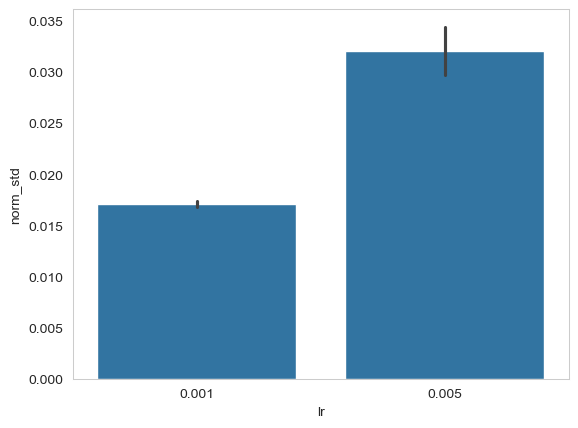

In [13]:
new_df = pd.DataFrame(rows)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.barplot(data = new_df, x = 'lr',y='norm_std',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')



In [16]:
# LR AND H norms (dim = 0)
k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
df = df[df.dim==k]
df = df[df['var']<-4]
u, z, mask, conditions  = generate_trials(
                            n_trials=2)
rows = []
for index, row in df.iterrows():
  
    net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
    net.recurrent_layer.weight.data = torch.tensor(row['w_rec'])
    net.recurrent_layer.bias.data = torch.tensor(row['bias'])
    net.input_layer.weight.data = torch.tensor(row['w_in'])
    net.input_layer.bias.data = torch.tensor(0.2).float()
    net.output_layer.weight.data = torch.tensor(row['w_out'])
    net.output_layer.bias.data = torch.tensor(-0.2).float()
    x = net.forward(u)
    net.sigma_in = .1
    n_neurons = x.shape[2]
    pca = PCA()
    pca.fit(x.detach().numpy().reshape(-1,x.shape[2]))
    
    U = pca.components_[:k,:].T
    #U = latent_net.module_.q[:2,:].t().detach()
    w = net.recurrent_layer.weight.data
    #w = w-np.eye(50)
    w_in = net.input_layer.weight.data
    
    b = net.recurrent_layer.bias.data
    
    H = w @ U 
    rows.append({'lr':row['lr'],
                'lambda_std':row['lambda_std'],
                 'norm_std':np.std(np.linalg.norm(H,axis=0))})

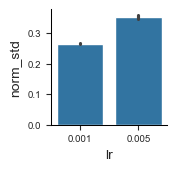

In [18]:
new_df = pd.DataFrame(rows)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.barplot(data = new_df, x = 'lr',y='norm_std',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')



In [37]:
# LR AND magnitude of vector field along trajectories
k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
df = df[df.dim==k]
df = df[df['var']<-4]
u, z, mask, conditions  = generate_trials(
                            n_trials=2)
rows = []
for index, row in df.iterrows():
  
    net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
    net.recurrent_layer.weight.data = torch.tensor(row['w_rec'])
    net.recurrent_layer.bias.data = torch.tensor(row['bias'])
    net.input_layer.weight.data = torch.tensor(row['w_in'])
    net.input_layer.bias.data = torch.tensor(0.2).float()
    net.output_layer.weight.data = torch.tensor(row['w_out'])
    net.output_layer.bias.data = torch.tensor(-0.2).float()
    x = net.forward(u)
    f = -x + torch.relu(net.recurrent_layer(x)+net.input_layer(u))
    rows.append({'lr':row['lr'],
                 'norm_std':torch.mean(torch.linalg.norm(f,dim=2)).detach().cpu().numpy().item()})
new_df = pd.DataFrame(rows)

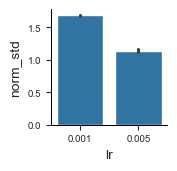

In [38]:
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.barplot(data = new_df, x = 'lr',y='norm_std',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')


In [47]:
# LR AND variance in n-1 dimension
k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
df = df[df.dim==k]
df = df[df['var']<-4]
u, z, mask, conditions  = generate_trials(
                            n_trials=2)
rows = []
for index, row in df.iterrows():
  
    net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
    net.recurrent_layer.weight.data = torch.tensor(row['w_rec'])
    net.recurrent_layer.bias.data = torch.tensor(row['bias'])
    net.input_layer.weight.data = torch.tensor(row['w_in'])
    net.input_layer.bias.data = torch.tensor(0.2).float()
    net.output_layer.weight.data = torch.tensor(row['w_out'])
    net.output_layer.bias.data = torch.tensor(-0.2).float()
    x = net.forward(u).detach().cpu().numpy()
    pca = PCA().fit(x.reshape(-1,x.shape[2]))
    variance = pca.explained_variance_ratio_[k-1]
    rows.append({'lr':row['lr'],
                 'variance':variance})
new_df = pd.DataFrame(rows)

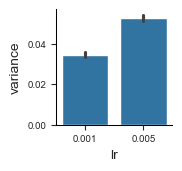

In [48]:
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.barplot(data = new_df, x = 'lr',y='variance',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

In [7]:
# LR AND variance in n-1 dimension
k = 4
df = original_df.copy()
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = np.log(df['var'])
#df = df[df.dim==k]
#df = df[df['var']<-2]
u, z, mask, conditions  = generate_trials(
                            n_trials=2)
def normal(x,mu,sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)/sigma/np.sqrt(2*np.pi)
rows = []
for index, row in df.iterrows():
    try:
        net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
        net.recurrent_layer.weight.data = torch.tensor(row['w_rec'])
        net.recurrent_layer.bias.data = torch.tensor(row['bias'])
        net.input_layer.weight.data = torch.tensor(row['w_in'])
        net.input_layer.bias.data = torch.tensor(0.2).float()
        net.output_layer.weight.data = torch.tensor(row['w_out'])
        net.output_layer.bias.data = torch.tensor(-0.2).float()
        x = net.forward(u).detach().cpu().numpy()
        pca = PCA().fit(x.reshape(-1,x.shape[2]))
        variance = pca.explained_variance_ratio_[k-1] - pca.explained_variance_ratio_[k]
        y = np.exp(-np.diff(np.log(pca.explained_variance_ratio_)))
        x = np.arange(1,net.n)
        popt, pcov = opt.curve_fit(normal, x, y, method="trf")
        #std = np.std(np.exp(-np.diff(np.log(pca.explained_variance_ratio_[:10]))))
        rows.append({'lr':row['lr'],
                     'mu':popt[0],
                     'std':popt[1],
                     'k_inertia':row['k_inertia']})
    except:
        continue
new_df = pd.DataFrame(rows)



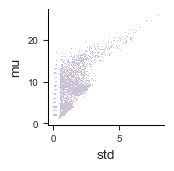

In [8]:

fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.histplot(data = new_df, x = 'std',y='mu',hue = 'lr',ax=ax,legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

In [19]:
df = original_df.copy()
#df = df[df.sigma_rec==0.]
# Restrict to networks with dim and compute variance above dim
dim = 5

df = df[df.lr==.005]
df = df[df.dim == dim]
#df = df[df.weight_decay == .008]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x,dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim-1])
df['var'] = np.log(df['var'])

df.sort_values('var',ascending=True).head(20)

#original_df.weight_decay = original_df.weight_decay == 0.001c

,model_id,w_rec,w_in,w_out,bias,mse_z,epochs,sigma_rec,sigma_in,weight_decay,...,lambda_std,n,lvar,dim,k,inertia,null_inertia,variance,var,k_inertia
2368,rEVmnYGT,"[[0.0, -0.02919281, -0.0030434832, 0.000635396...","[[-0.18762259, 0.29148647], [0.18064947, 0.118...","[[-0.030340062, 0.0625198, -0.04218304, -0.084...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.087511,1000,0.5,0.1,0.001,...,0.4,100,6.812921,5,5,"[0.9446026666666667, 0.5292334583333334, 0.240...","[[0.9956316502620777, 0.987828712167325, 0.982...","[0.48585826, 0.37400278, 0.08873908, 0.0422108...",-8.350878,0.001290
2347,cUbx7PeR,"[[0.0, -0.008371658, 0.026509782, 0.016539056,...","[[-0.025703078, -0.3259526], [-0.18030271, -0....","[[0.07229906, 0.08220908, -0.007207974, 0.0621...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.070660,1000,0.5,0.1,0.001,...,0.4,100,6.812921,5,5,"[0.9333015833333334, 0.5118244583333333, 0.172...","[[0.996787342045922, 0.9931042589463179, 0.991...","[0.47896522, 0.4123734, 0.060428865, 0.0365364...",-8.181885,0.004602
2144,kd8HU2F8,"[[0.0, -0.039987843, 0.04898045, -0.03068274, ...","[[0.27694866, 0.13294277], [0.019875703, -0.26...","[[0.01778007, 0.0161471, 0.07565194, -0.033932...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.027494,1000,0.5,0.1,0.001,...,0.4,100,4.641589,5,6,"[0.95383675, 0.5475625833333333, 0.32112941666...","[[0.9945635409957189, 0.9954252908348505, 0.99...","[0.47586116, 0.34928635, 0.09581924, 0.0426988...",-7.675581,0.071675
2152,1oaZ4frz,"[[0.0, -0.14682607, 0.053953137, -0.0122380685...","[[-0.22732712, -0.1630721], [0.024928303, 0.24...","[[-0.08920659, 0.107285224, 0.049155768, -0.02...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.047712,1000,0.5,0.1,0.001,...,0.4,100,4.641589,5,5,"[0.9387340731223455, 0.5682575530429255, 0.248...","[[0.9821840914884554, 0.99258379675085, 0.9784...","[0.48183724, 0.37474033, 0.08462467, 0.0446013...",-7.663642,0.024243
2163,IU8qyzuK,"[[0.0, 0.0011673702, 0.0015268762, 0.010990605...","[[0.17098323, 0.18879882], [0.16136944, 0.1850...","[[-0.030335683, 0.08656743, 0.050139282, 0.030...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.044995,1000,0.5,0.1,0.001,...,0.4,100,4.641589,5,5,"[0.9494182457848538, 0.6157343013111918, 0.299...","[[0.9721586324443059, 0.9951047259525277, 0.98...","[0.43590015, 0.37634194, 0.10572024, 0.0455516...",-7.469526,0.012301
2043,YqF0Smw2,"[[0.0, -0.052532673, -0.022302827, 0.004923617...","[[0.17827162, 0.24665955], [0.22610427, -0.205...","[[-0.025323724, 0.031856824, -0.014900081, -0....","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.047246,1000,0.5,0.1,0.001,...,0.4,100,3.162278,5,5,"[0.9667646694362776, 0.6095319908723341, 0.320...","[[0.9811849089378663, 0.9888968299403058, 0.98...","[0.416362, 0.3339525, 0.11828911, 0.1000972, 0...",-7.343410,0.006219
2354,R68JpHd2,"[[0.0, -0.07748765, -0.015691891, 0.010421717,...","[[-0.28414896, 0.014077099], [-0.013993959, 0....","[[0.009435297, -0.011381094, -0.022839012, 0.0...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.046854,1000,0.5,0.1,0.001,...,0.4,100,6.812921,5,5,"[0.9373660833333334, 0.5616638333333334, 0.273...","[[0.9959018130121707, 0.9854986860794686, 0.99...","[0.46209195, 0.40975213, 0.059208747, 0.047315...",-7.317808,0.035295
2359,JQKkfERo,"[[0.0, 0.022979025, -0.029529238, 0.03684275, ...","[[-0.075947925, 0.20426454], [-0.221349, 0.030...","[[-0.054780893, 0.03529306, 0.015250577, 0.079...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.055887,1000,0.5,0.1,0.001,...,0.4,100,6.812921,5,5,"[0.9536305, 0.57769, 0.3119300208333333, 0.101...","[[0.9869355433235594, 0.9955533363079564, 0.98...","[0.46322033, 0.3831204, 0.082104556, 0.0367548...",-7.224130,0.038814
2148,BRq9yIfw,"[[0.0, -0.012498111, -0.028478649, 0.050434228...","[[-0.21437497, 0.20111595], [0.23434076, -0.20...","[[-0.03891317, 0.020713897, 0.073982455, -0.08...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.025630,1000,0.5,0.1,0.001,.

## Analyze single model

6
(100, 3750)


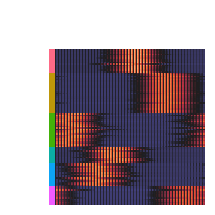

In [29]:
df = original_df.copy()
#net = torch.load('net.pth')
model_data = df[df.model_id=='kspGBirT']
net = Net(n=100,input_size = 2,dale=False,base_in=0.2)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.input_layer.bias.data = torch.tensor(0.2).float()
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.output_layer.bias.data = torch.tensor(-0.2).float()
#net.activation = nn.Softplus(beta=torch.tensor(model_data['beta'].item()))
net.sigma_in = 0.
net.sigma_rec = 0.

u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()


# Condition averages
rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'theta': conditions[k]['theta'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby('theta').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

# Remove outlier neurons
# z_scores = np.abs(stats.zscore(np.mean(x, axis=(0, 1))))
# good_indices = np.where(z_scores < 2)[0]
# responses = responses[good_indices,:]
#n_active = np.mean(responses, axis=1) > .025
n_active =np.mean(responses, axis=1) > .025
#lower_percentile = np.percentile(np.mean(responses, axis=1),5)
responses = responses[np.mean(responses, axis=1) > .025, :]

# Compute number of active units


# z_score
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]



            
#_,k = compute_k(responses,5,25,.05)
k = model_data.k.values[0]
print(k)
print(responses.shape)
clustering = KMeans(n_clusters=k,n_init=20).fit(responses)
labels  = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort,:]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)),row_cluster=False, col_cluster=False, row_colors=row_colors,figsize=(2.25,2.25),cbar_pos=None, xticklabels=False, yticklabels=False,center=0)
ax = g.ax_heatmap

# g.savefig('Figures/Fig_2afc_b.jpg',
#     format='jpeg',
#     dpi=450,
#             bbox_inches='tight'
# )

In [10]:
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(50,s=1)



net.sigma_in =0.05
net.sigma_rec =0
x = net.forward(u).detach().numpy()

rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        for neuron in range(x.shape[2]):
            rows.append({'trial':k,
                         'theta':conditions[k]['theta']*180/np.pi,
                        't':t,
                         'neuron': neuron,
                         'cluster': labels[neuron],
                         'response': x[k,t,neuron]})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['theta','neuron']).mean().reset_index()
# fig = plt.figure(figsize=(1.5,1.5))
# gs = gridspec.GridSpec(1,1)
# ax=fig.add_subplot(gs[0,0])

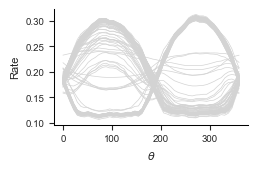

In [11]:

fig = plt.figure(figsize=(2.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

for neuron in range(x.shape[2]):
    sns.lineplot(data = new_df_mean[new_df_mean.neuron==neuron], x = 'theta',y='response',color='lightgray',lw = .5,ax=ax)
# for cluster in range(4):
#     sns.lineplot(data = new_df_mean[new_df_mean.cluster==cluster], x = 'theta',y='response',color='gray',lw = 1,errorbar='sd',ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel(r'$\theta$',fontsize=8)
ax.set_ylabel("Rate",fontsize=8)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('/Users/cl1704/PycharmProjects/clustering_in_rnns/Figures/Fig_2afc_b.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

<Axes: ylabel='Count'>

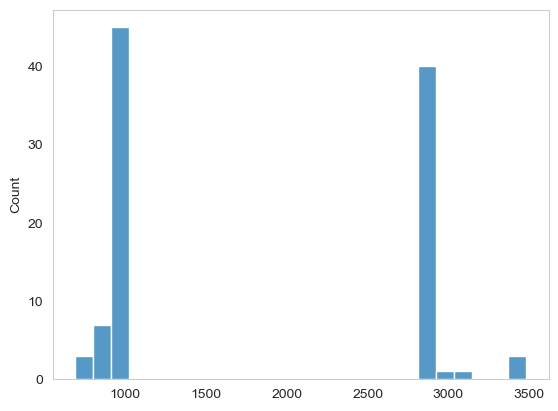

In [12]:
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(50,s=1)


plt.figure()
sns.histplot(x=np.argmax(responses,axis=1),bins = 25)
# fig = plt.figure(figsize=(1.5,1.5))
# gs = gridspec.GridSpec(1,1)
# ax=fig.add_subplot(gs[0,0])

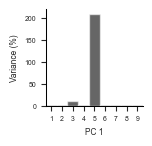

In [160]:
## PCA
fig = plt.figure(figsize=(1.25,1.25))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
pca = PCA().fit(responses.T)
sns.barplot(x = np.arange(1,10),y=np.exp(-np.diff(np.log(pca.explained_variance_ratio_[:10]))),alpha=.6,ax=ax,color='k',width=1)
ax.set_xlabel("PC 1", fontsize=6)
ax.set_ylabel("Variance (%)", fontsize=6)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=5, bottom=True)
ax.yaxis.set_tick_params(labelsize=5, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,1)
plt.savefig('/Users/cl1704/PycharmProjects/clustering_in_rnns/Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4/Figures/Fig1c.jpg'

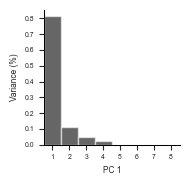

In [13]:
## PCA
fig = plt.figure(figsize=(1.75,1.75))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
pca = PCA().fit(responses.T)
sns.barplot(x = np.arange(1,9),y=pca.explained_variance_ratio_[:8],alpha=.6,ax=ax,color='k',width=1)
ax.set_xlabel("PC 1", fontsize=6)
ax.set_ylabel("Variance (%)", fontsize=6)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=5, bottom=True)
ax.yaxis.set_tick_params(labelsize=5, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,1)
plt.savefig('Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4/Figures/Fig1c.jpg'

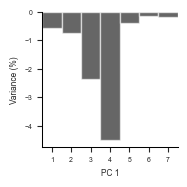

In [106]:
## PCA
fig = plt.figure(figsize=(1.75,1.75))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
pca = PCA().fit(responses.T)
sns.barplot(x = np.arange(1,8),y=np.diff(np.log(pca.explained_variance_ratio_[:8])),alpha=.6,ax=ax,color='k',width=1)
ax.set_xlabel("PC 1", fontsize=6)
ax.set_ylabel("Variance (%)", fontsize=6)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=5, bottom=True)
ax.yaxis.set_tick_params(labelsize=5, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,1)
plt.savefig('Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4/Figures/Fig1c.jpg'

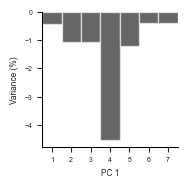

In [91]:
## PCA
fig = plt.figure(figsize=(1.75,1.75))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
pca = PCA().fit(responses.T)
sns.barplot(x = np.arange(1,8),y=np.diff(np.log(pca.explained_variance_ratio_[:8])),alpha=.6,ax=ax,color='k',width=1)
ax.set_xlabel("PC 1", fontsize=6)
ax.set_ylabel("Variance (%)", fontsize=6)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=5, bottom=True)
ax.yaxis.set_tick_params(labelsize=5, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,1)
plt.savefig('Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )


In [144]:
plt.figure()
sns.histplot(np.mean(x,axis=(0,1)),bins=25)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=tuple, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

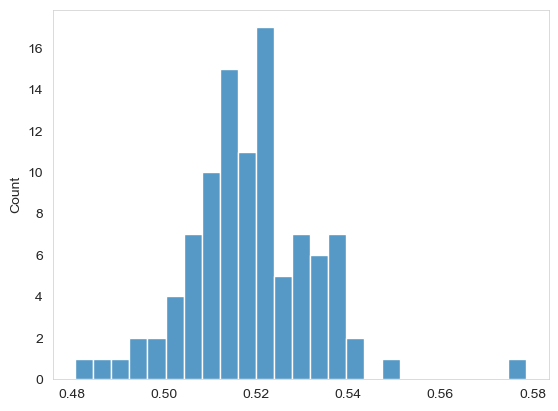

In [156]:
plt.figure()
sns.histplot(np.std(x,axis=(0,1)),bins=25)

In [271]:
np.std(np.std(x,axis=(0,1)))

0.12270283

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4/Figures/Fig_2afc_c.jpg'

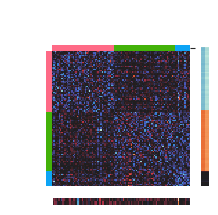

In [20]:


#sort=np.argsort(labels)
w = net.recurrent_layer.weight.data
w_in = net.input_layer.weight.data
w_out = net.output_layer.weight.data


w = w[sort,:]
w = w[:,sort]
w_in = w_in[sort,:]
w_out = w_out[:,sort]

g = sns.clustermap(pd.DataFrame(w),center=0,row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors,figsize=(2.25,2.25),cbar_pos=None, xticklabels=False, yticklabels=False)

g.gs.update(left=0.05, right=0.85,bottom=.15)
gs2 = matplotlib.gridspec.GridSpec(1,1, left=.9,top=.77,bottom=.15)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(w_in,ax=ax2,cbar=False,xticklabels=False,yticklabels=False,center=0)

gs3 = matplotlib.gridspec.GridSpec(1,1,left=.24,top=.1,right=.85)
ax3 = g.fig.add_subplot(gs3[0])
sns.heatmap(w_out,ax=ax3,cbar=False,xticklabels=False,yticklabels=False,center=0)


g.savefig('Figures/Fig_2afc_c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

<Axes: ylabel='Probability'>

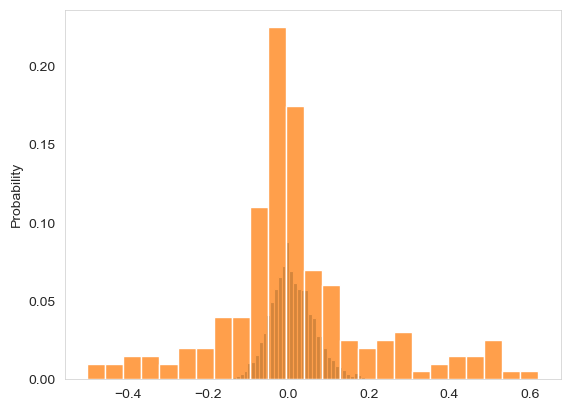

In [81]:
plt.figure()
sns.histplot(w.flatten(),stat = 'probability')
sns.histplot(w_in.flatten(),stat = 'probability')

<Axes: ylabel='Count'>

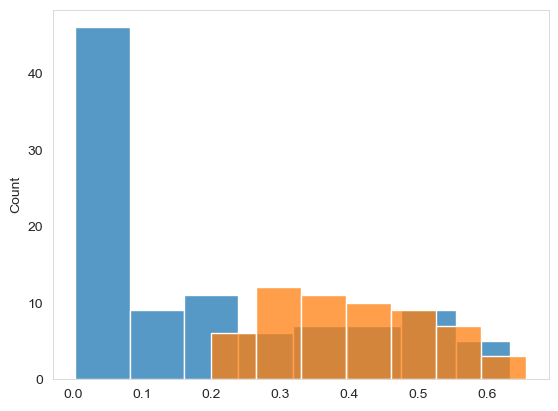

In [80]:
plt.figure()
sns.histplot(np.linalg.norm(w_in,axis=1))
sns.histplot(np.linalg.norm(w,axis=1))

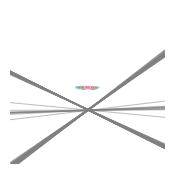

In [21]:
from sklearn.decomposition import PCA
#import seaborn as sns
from sympy import *
from sympy.plotting import plot
from sympy.plotting import plot_implicit

x = net.forward(u)
net.sigma_in = .1
n_neurons = x.shape[2]
#Restrict to act
x = x[:,:,n_active]
n_neurons = x.shape[2]
pca = PCA()
pca.fit(x.detach().numpy().reshape(-1,x.shape[2]))

U = pca.components_[:6,:].T
#U = latent_net.module_.q[:2,:].t().detach()
w = net.recurrent_layer.weight.data
w = w[n_active,:]
w = w[:,n_active]
#w = w-np.eye(50)
w_in = net.input_layer.weight.data

b = net.recurrent_layer.bias.data

H = w @ U 
#H = H[sort,:]
proj_rates = pca.transform(x.detach().reshape(-1,x.shape[2]))
proj_rates = proj_rates.reshape(-1,75,x.shape[2])

fig = plt.figure(figsize=(2,2))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

lim =6
xx,yy = np.linspace(-lim,lim), np.linspace(-lim,lim)
x,y = np.meshgrid(xx,yy)
for i in range(n_neurons):
#for i in np.argwhere(labels==0):

    magnitude = np.linalg.norm(H[i,:].numpy())

    #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
    ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors='gray',linewidths=.75,alpha=.5)

#for i in range(n_neurons):
# for i in np.argwhere(labels==0):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75,alpha=1)


# for i in np.argwhere(labels==1):
# 
#     magnitude = np.linalg.norm(H[i,:].numpy())
# 
#     #ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],colors=network_pal.as_hex()[labels[i]],linewidths=.75)
#     ax.contour(x, y, x*H[i,0].numpy() + y*H[i,1].numpy()+b[i].numpy(), [0],color='gray',linewidths=.75)


# for i in range(25):
#     ax.plot(proj_rates[i,57:,0],proj_rates[i,57:,1],lw=1)
       

x = net.forward(u).detach().cpu().numpy()

pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'theta': conditions[k]['theta'],
                     't': t,
                     'z_1': x_proj[k, t, 0],
                     'z_2': x_proj[k, t, 1], })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['theta', 't']).mean().reset_index()


#sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.1,edgecolor=None)
palette = sns.husl_palette(n_colors = 50,s = 1)
# sns.scatterplot(data=new_df_mean[new_df_mean.t<20], x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5,hue ='t')
sns.scatterplot(data=new_df[new_df.t==74], x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.35, hue='theta',palette=palette)
sns.scatterplot(data=new_df_mean[new_df_mean.t==74], x='z_1', y='z_2', ax=ax, legend=False, s=5, alpha=1, hue='theta',palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("",fontsize=8)
ax.set_ylabel("",fontsize=8)
plt.savefig('/Users/cl1704/PycharmProjects/clustering_in_rnns/Figures/Fig1c.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight'
            )

In [242]:
H.shape

torch.Size([54, 6])

<Axes: ylabel='Count'>

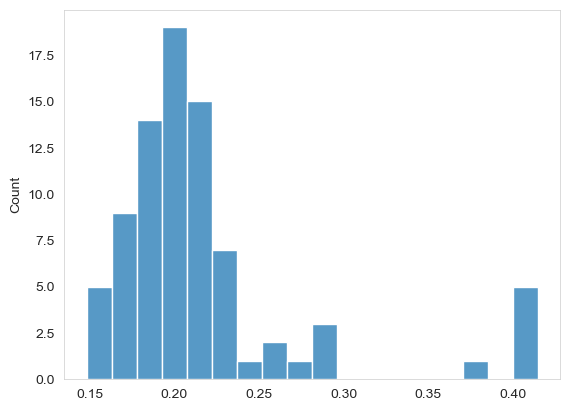

In [43]:
plt.figure()
sns.histplot(torch.linalg.norm(H,dim=1))

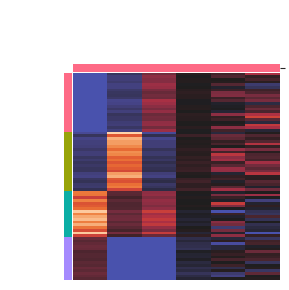

In [58]:


# sort=np.argsort(labels)
# 
H = H[sort,:]

g = sns.clustermap(pd.DataFrame(H),center=0,row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors,figsize=(3,3),cbar_pos=None, xticklabels=False, yticklabels=False,vmin=-.1)

ax = g.ax_heatmap

g.savefig('Figures/Fig_2afc_c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'

)

<Axes: ylabel='Count'>

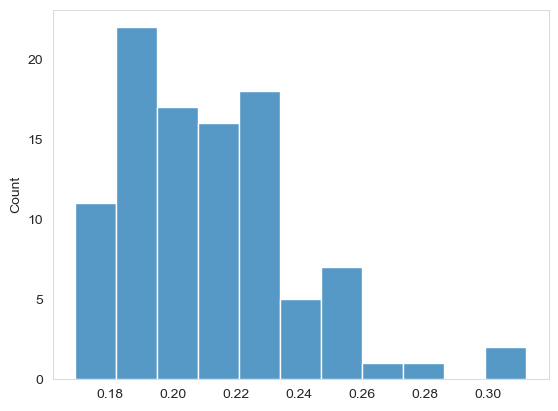

In [154]:
plt.figure()
sns.histplot(np.linalg.norm(H,axis=1))
#sns.histplot(np.linalg.norm(w_in,axis=1),color='tab:orange')

<Axes: ylabel='Count'>

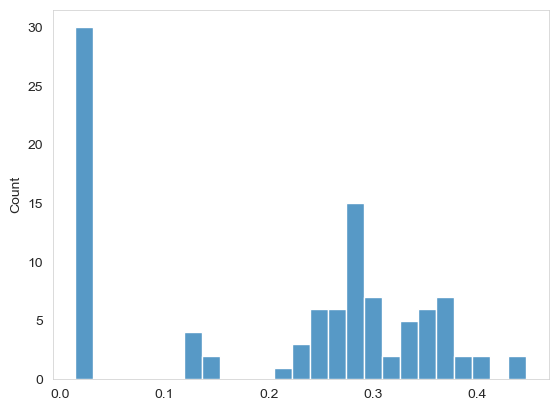

In [114]:
plt.figure()
sns.histplot((np.std(x,axis=(0,1))),bins=25)

NameError: name 'clf' is not defined

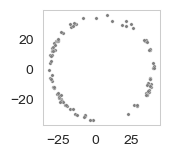

In [124]:
from scipy.stats import special_ortho_group

# x_rshp = responses
pca = TSNE()
x_proj = pca.fit_transform(responses)
# 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = responses
y = labels
# clf = LinearDiscriminantAnalysis(tol=1e-1)
# clf.fit(X, y)
# x_proj = clf.transform(responses)

lda = LinearDiscriminantAnalysis()

#lda = TSNE(perplexity = 5)
#lda = PCA()
#reducer = umap.UMAP()
# parameters = {'tol':10**np.linspace(-5,0,25)}
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(lda, parameters,refit=True,error_score = np.nan,cv=5)
# clf.fit(X, y)
# lda = clf.best_estimator_
# x_proj = lda.fit_transform(X,y)
x_proj = PCA().fit_transform(X)

#x_proj_jitter = x_proj + 1000*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)

lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)

fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], c='gray',s=6,alpha=1)
# sns.scatterplot(x=x_proj_jitter[np.argsort(labels), 0], y=x_proj_jitter[np.argsort(labels), 1], c='gray',s=6,alpha=1)
centers_proj = clf.transform(clustering.cluster_centers_)
    
    
    # total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
    # r2 = kmeans.inertia_/total_variance
    # #x_proj = clf.fit_transform(responses)
    # sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1],c=row_colors,s=1,alpha=1)
    # 
#sns.scatterplot(x=centers_proj[:, 0], y=centers_proj[:, 1], color='k',s=3,alpha=1,ax=ax,edgecolor=None)

# sns.scatterplot(x=x_proj_jitter[np.argsort(labels), 0], y=x_proj_jitter[np.argsort(labels), 1], c=row_colors,s=4,alpha=1)
#sns.kdeplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], hue = ,s=10,alpha=1)

#ax.scatter(x_proj[np.argsort(labels), 0],x_proj[np.argsort(labels), 1],x_proj[np.argsort(labels), 2],c=row_colors,s=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=8,bottom=True)
ax.yaxis.set_tick_params(labelsize=8,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
# ax.set_xlim(-30,30)
# ax.set_ylim(-30,30)
plt.savefig('Figures/Fig1c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cl1704/PycharmProjects/clustering_in_rnns/Experiment_4/Figures/Exp_2_Fig_1.jpg'

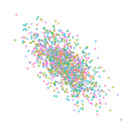

In [22]:

#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(50,s=1)



net.sigma_in =0.05
net.sigma_rec =0
x = net.forward(u).detach().numpy()
#x = (x-np.mean(x,axis=(0,1),keepdims=True)) / np.std(x,axis=(0,1),keepdims=True)
#x = net(u)
n_components=2
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial':k,
                     'theta':conditions[k]['theta'],
                    't':t,
                    'z_1':x_proj[k,t,0],
                    'z_2':x_proj[k,t,1],})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['theta','t']).mean().reset_index()
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])


sns.scatterplot(data=new_df[new_df.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=3,alpha=.5,hue='theta',palette = palette)
# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions

# centers = clustering.cluster_centers_
# model_trajectories = np.zeros((responses.shape[1],responses.shape[0]))
# for i in range(responses.shape[0]):
#     model_trajectories[:,i] = centers[clustering.predict(responses[None,i,:]),:]
# model_trajectories = model_trajectories.reshape(-1,75,150)
# model_trajectories = model_trajectories[:,-1,:]
# model_trajectories = model_trajectories.reshape(-1,150)
# pca = PCA(n_components=2).fit(model_trajectories)
# #proj_responses =pca.transform(responses.T).T
# proj_centers = pca.transform(model_trajectories)
#sns.scatterplot(x = proj_centers[:,0],y=proj_centers[:,1],color='k',legend=False,ax=ax,s=3,alpha=1)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1",fontsize=7)
ax.set_ylabel("PC 2",fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.gca().patch.set_alpha(0)
# ax.set_xlim(-1.25,1.25)
# ax.set_ylim(-1.25,1.25)
matplotlib.rcParams['savefig.transparent'] = True
fig.savefig('Figures/Exp_2_Fig_1.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight',transparent=True)


<Axes: xlabel='None', ylabel='Count'>

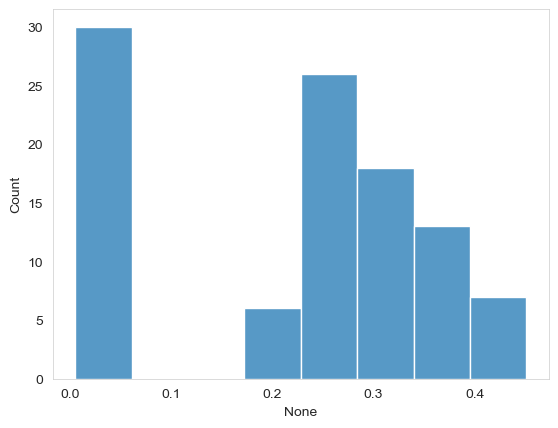

In [117]:
plt.figure()
x = net.forward(u)
sns.histplot(x = torch.mean(x,dim=[0,1]).detach())

/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_47134/4258637645.py:27: UserWarning: 
The palette list has fewer values (50) than needed (75) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=new_df,x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='t',palette = palette)


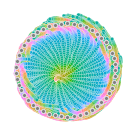

In [576]:
u, z, mask, conditions  = generate_trials(
                            n_trials=50)
net.sigma_in =0.05
#net.activation = torch.nn.Softplus(beta=2)
net.sigma_rec = 0

x = net(u)
output = net.output_layer(x).detach().numpy()
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial':k,
                     'theta':conditions[k]['theta'],
                    't':t,
                    'z_1':output[k,t,0].item(),
                    'z_2':output[k,t,1].item(),
                     'target_1':z[k,t,0].item(),
                    'target_2':z[k,t,1].item(),})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['theta','t']).mean().reset_index()
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])



sns.scatterplot(data=new_df,x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='t',palette = palette)

sns.scatterplot(data=new_df[new_df.t==74],x='target_1',y='target_2',ax=ax,legend=False,s=6,alpha=1,color='gray')

# Plot targets



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1",fontsize=7)
ax.set_ylabel("PC 2",fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# ax.set_xlim(-1.2,1.2)
# ax.set_ylim(-1.2,1.2)
fig.savefig('Figures/Exp_2_Fig_2.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


In [578]:
.1*75

7.5

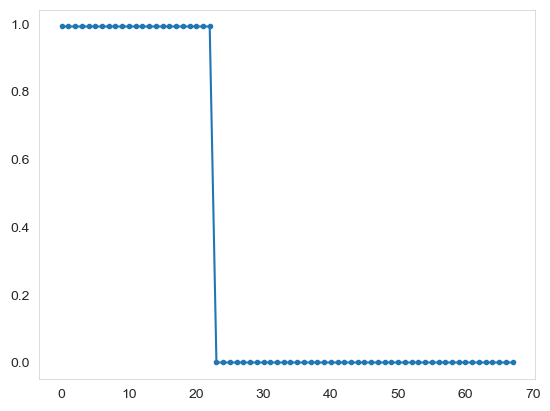

In [582]:
plt.figure()
plt.plot(u[0,7:,0],marker='.')

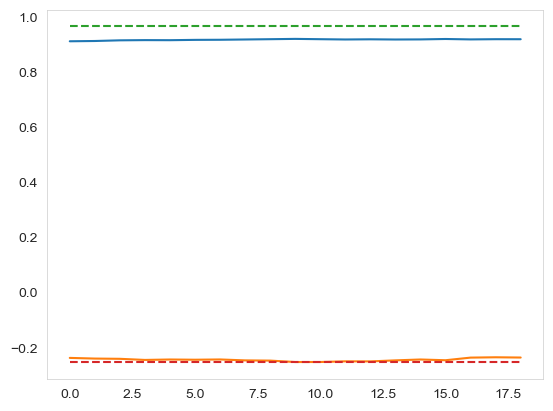

In [163]:
plt.figure()
trial = 20
plt.plot(output[trial,56:,0])
plt.plot(output[trial,56:,1])
plt.plot(z[trial,56:,0],linestyle='--')
plt.plot(z[trial,56:,1],linestyle='--')

<Axes: ylabel='None'>

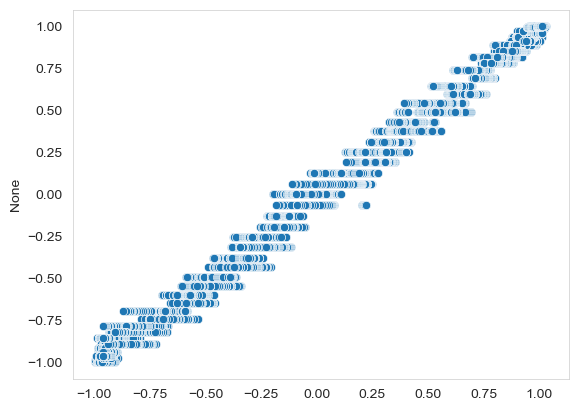

In [164]:
plt.figure()
sns.scatterplot(x = output[:,56:,1].flatten(),y =z[:,56:,1].flatten() )

In [100]:
from sklearn.metrics import r2_score

r2_score(z[:,56:,:].detach().flatten(), net.output_layer(x[:,56:,:]).detach().flatten())

-0.5387198037724465

In [108]:

mse = nn.MSELoss()
#return mse(self.output_layer(x)*mask, z*mask) / mse(z*mask,torch.zeros_like(z*mask))
z = z[:,56:,:]
z_centered = z - torch.mean(z,dim=[0,1],keepdim=True)

mse(net.output_layer(x)[:,56:,:], z) / mse(z_centered,torch.zeros_like(z_centered))


tensor(1.5600, grad_fn=<DivBackward0>)

NameError: name 'torcheval' is not defined

In [94]:
mse(z_centered[:,56:,:],torch.zeros_like(z_centered[:,56:,:]))

tensor(nan)

In [96]:
net.output_layer(x)[:,56:,:]

tensor([[[0.9193, 0.9239],
         [0.9026, 0.9057],
         [0.8872, 0.8881],
         ...,
         [0.8832, 0.8810],
         [0.8806, 0.8776],
         [0.8666, 0.8629]],

        [[1.0064, 1.0054],
         [0.9845, 0.9848],
         [0.9583, 0.9594],
         ...,
         [0.8304, 0.8271],
         [0.8184, 0.8141],
         [0.8182, 0.8122]],

        [[0.8601, 0.8564],
         [0.8968, 0.8931],
         [0.9310, 0.9277],
         ...,
         [0.9528, 0.9617],
         [0.9354, 0.9449],
         [0.9147, 0.9240]],

        ...,

        [[0.8977, 0.8910],
         [0.9342, 0.9284],
         [0.9700, 0.9652],
         ...,
         [0.8918, 0.9030],
         [0.8758, 0.8854],
         [0.8683, 0.8743]],

        [[0.8181, 0.8135],
         [0.8459, 0.8446],
         [0.8699, 0.8715],
         ...,
         [0.9644, 0.9762],
         [0.9492, 0.9619],
         [0.9269, 0.9398]],

        [[0.9789, 0.9864],
         [0.9782, 0.9835],
         [0.9647, 0.9675],
         ...,
 

In [68]:
mse(net.output_layer(x[:,56:,:]), z[:,56:,:])

tensor(0.0310, grad_fn=<MseLossBackward0>)

In [66]:
mse(z[:,56:,:],torch.zeros_like(z[:,56:,:]))

tensor(1.0240)

## Single unit tuning

In [548]:
def compute_k(responses,n_init,max_clusters,threshold):
    inertia = []
    for n_clusters in range(1, np.min([max_clusters,responses.shape[0]])):
        kmeans = KMeans(n_clusters=n_clusters,n_init='auto').fit(responses)
        inertia.append(kmeans_r2(kmeans,responses))
    #inertia = -np.diff(inertia)
    for j in range(len(inertia)):
        if inertia[j] < threshold:
            break
    k = j + 1
    return inertia, k

# Function for computing r2 for kmeans model
def kmeans_r2(kmeans, responses ):
    n_neurons = responses.shape[0]
    cluster_means = kmeans.cluster_centers_
    total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
    return kmeans.inertia_ / total_variance

In [568]:
u, z, mask, conditions  = generate_trials(
                            n_trials=25)
net.sigma_in = .02
net.sigma_rec = 0
x = net(u).detach().cpu().numpy()

x = x - np.mean(x,axis = (0,1),keepdims=True)
x = x / np.std(x,axis = (0,1),keepdims=True)

#Restrict to neurons which are significantly modulated by the stimulus
rows = []
for k in range(u.shape[0]):
    for neuron in range(x.shape[2]):
        for t in range(x.shape[1]):
            rows.append({'trial': k,
                         'neuron': neuron,
                            'theta': conditions[k]['theta'],
                         'response': np.mean(x[k, t, neuron])})
df = pd.DataFrame(rows)
df = df.groupby(['trial','neuron','theta']).mean().reset_index()
p_values = []
for neuron in range(x.shape[2]):
    regressor_OLS = sm.OLS(endog=df[df.neuron == neuron].response.values,
                                                            exog=df[df.neuron == neuron]['theta'].values).fit()
    p_values.append(regressor_OLS.pvalues.min())
active_units = np.argwhere(np.array(p_values) < .01)[:, 0]
x = x[:, :, active_units]


rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'theta': conditions[k]['theta'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby('theta').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

# Compute k


In [569]:
inertia, k = compute_k(responses, 5, 25, .1)

In [570]:
k

5

In [571]:
len(active_units)

154

<Axes: xlabel='theta', ylabel='response'>

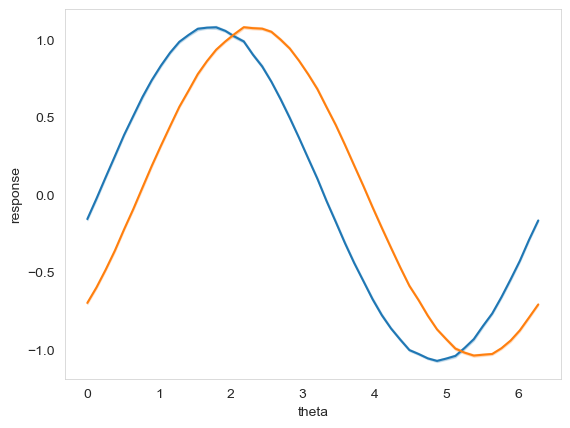

In [572]:




#k = model_data.k.values[0]

clustering = KMeans(n_clusters=k,n_init=20).fit(responses)
labels  = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort,:]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)


g.savefig('Figures/Fig_2afc_b.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

rows = []
for k in range(u.shape[0]):
    for neuron in range(x.shape[2]):
        rows.append({'trial': k,
                     'neuron': neuron,
                     'cluster':labels[neuron],
                        'theta': conditions[k]['theta'],
                     'response': np.mean(x[k, :, neuron])})
df = pd.DataFrame(rows)

plt.figure()
sns.lineplot(data = df[df.neuron==0], x = 'theta',y = 'response')
sns.lineplot(data = df[df.neuron==1], x = 'theta',y = 'response')
#sns.lineplot(data = df[df.neuron==18], x = 'theta',y = 'response')

<Axes: xlabel='theta', ylabel='response'>

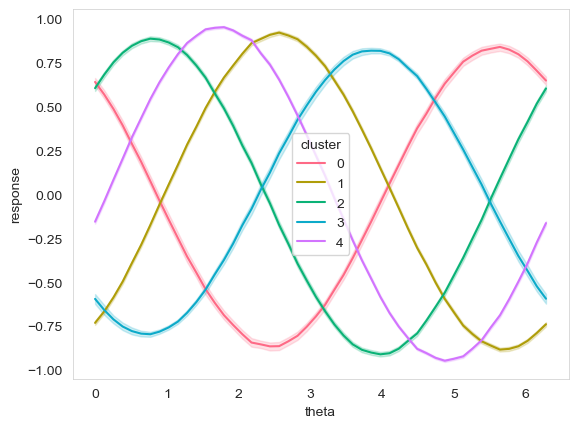

In [573]:
plt.figure()
sns.lineplot(data = df, x = 'theta',y = 'response',hue = 'cluster',palette = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1))

In [73]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## Training

In [5]:
#from ParametricWMTask import generate_trials
u, z, mask, conditions = generate_trials(n_trials=50)

device= 'cpu'

net = Net(n=100, input_size=u.shape[2], dale=False, sigma_in = 0.02,sigma_rec=0. ).to(device)


# Fit with penalty
net.fit(u.to(device=device), z.to(device=device), mask.to(device=device), lr=.02,
    epochs=2000,
    conditions=conditions,
    verbose=True,
    lvar=0.,
    dim=2,
    weight_decay=0)


Epoch: 50/2000............. mse_z: 0.1274
Epoch: 100/2000............. mse_z: 0.1269
Epoch: 150/2000............. mse_z: 0.1266
Epoch: 200/2000............. mse_z: 0.1264
Epoch: 250/2000............. mse_z: 0.0955
Epoch: 300/2000............. mse_z: 0.0824
Epoch: 350/2000............. mse_z: 0.0769
Epoch: 400/2000............. mse_z: 0.0617
Epoch: 450/2000............. mse_z: 0.0357
Epoch: 500/2000............. mse_z: 0.0210
Epoch: 550/2000............. mse_z: 0.0090
Epoch: 600/2000............. mse_z: 0.0110
Epoch: 650/2000............. mse_z: 0.0162
Epoch: 700/2000............. mse_z: 0.0108
Epoch: 750/2000............. mse_z: 0.0050
Epoch: 800/2000............. mse_z: 0.0069
Epoch: 850/2000............. mse_z: 0.0035
Epoch: 900/2000............. mse_z: 0.0012
Epoch: 950/2000............. mse_z: 0.0180
Epoch: 1000/2000............. mse_z: 0.0174
Epoch: 1050/2000............. mse_z: 0.0027
Epoch: 1100/2000............. mse_z: 0.0038
Epoch: 1150/2000............. mse_z: 0.0010
Epoch: 1

KeyboardInterrupt: 

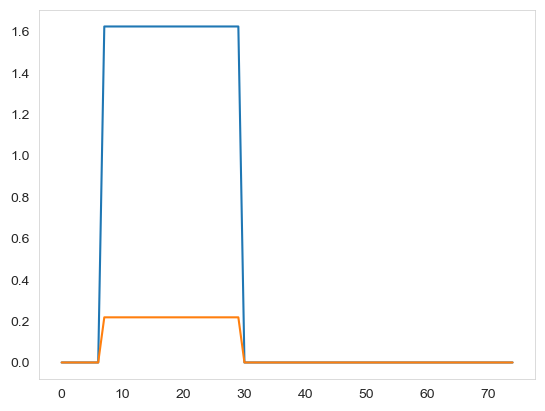

In [11]:
plt.figure()
plt.plot(u[6,:,0])
plt.plot(u[6,:,1])

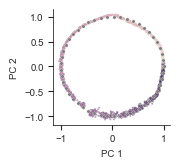

In [6]:

palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)

u, z, mask, conditions  = generate_trials(
                            n_trials=50)
#net.sigma_in =0
#net.sigma_in =.4
#net.sigma_rec = .25
#x = net.forward(u).detach().numpy()
x = net(u)
z = net.output_layer(x).detach().numpy()
n_components=2
pca = PCA(n_components=n_components)
pca.fit(x[:,:,:].detach().numpy().reshape(-1, x.shape[2]))
x_proj = pca.transform(x.detach().numpy().reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],n_components)
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial':k,
                     'theta':conditions[k]['theta'],
                    't':t,
                    'z_1':z[k,t,0],
                    'z_2':z[k,t,1],})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['theta','t']).mean().reset_index()
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
# coherences = np.sort(new_df.motion.unique())
# for i in range(len(coherences)):    
#     motion_df = new_df[new_df.motion == coherences[i]]
#     #ax.plot(motion_df[motion_df.t>=30].z_1.values,motion_df[motion_df.t>=30].z_2.values,color=palette[i],lw=1)
#     ax.plot(motion_df.z_1.values,motion_df.z_2.values,color=palette[i],lw=1)

    # ax.plot(motion_df[motion_df.t<30].z_1.values,motion_df[motion_df.t<30].z_2.values,color='gray',linestyle='--',alpha=.5,lw=1)
#new_df = new_df.groupby(['motion','t']).mean().reset_index()
#sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=2,alpha=.5,hue='theta')
sns.scatterplot(data=new_df[new_df.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=2,alpha=.5,hue='theta')
rows = []
thetas = np.linspace(0, 2*np.pi, 50)
for theta in thetas:
    rows.append({'x':np.cos(theta),'y':np.sin(theta)})
target_df = pd.DataFrame(rows)
sns.scatterplot(data=target_df,x = 'x',y='y',color='gray',ax=ax,s = 6)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("PC 1",fontsize=7)
ax.set_ylabel("PC 2",fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
fig.savefig('Figures/Exp_2_Fig_2.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


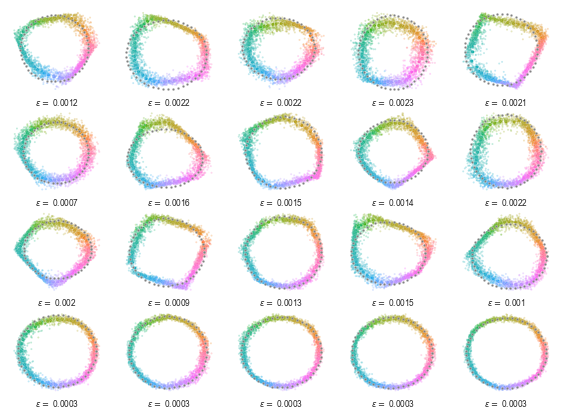

In [241]:
df_list = []
for filename in os.listdir('Experiment_4/Results_4'):
    f = os.path.join('Experiment_4/Results_4', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.0025]
original_df.threshold = original_df.threshold.astype(float)
original_df.weight_decay = original_df.weight_decay.astype(float)

fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(4,5)
u, z, mask, conditions  = generate_trials(
                    n_trials=50)
for i in range(4):
    for j in range(5):
            ax=fig.add_subplot(gs[i,j])
            df = original_df.copy()
            k = i+5
            if i<3:
                df['var'] = df.variance.apply(lambda x: compute_var(x,k))
                df = df[df.k==k]
                model_id = df.sort_values('var',ascending=True)['model_id'].values[j]#
            else:
                df['var'] = df.variance.apply(lambda x: compute_var(x,k))
                model_id = df.sort_values('mse_z',ascending=True)['model_id'].values[j]#
                
            model_data = original_df[original_df.model_id==model_id]
            net = Net(n=100,input_size = 2,dale=False)
            net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
            net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
            net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
            net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
            
       
            #net.sigma_in =0
            #net.sigma_in =.4
            #net.sigma_rec = .25
            #x = net.forward(u).detach().numpy()
            net.sigma_in = 0.1
            x = net(u)
            z = net.output_layer(x).detach().numpy()
            n_components=3
            pca = PCA(n_components=n_components)
            pca.fit(x[:,:,:].detach().numpy().reshape(-1, x.shape[2]))
            x_proj = pca.transform(x.detach().numpy().reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],n_components)
            rows = []
            for k in range(u.shape[0]):
                for t in range(u.shape[1]):
                    rows.append({'trial':k,
                                 'theta':conditions[k]['theta'],
                                't':t,
                                'z_1':z[k,t,0],
                                'z_2':z[k,t,1],})
            new_df = pd.DataFrame(rows)
            new_df_mean =new_df.groupby(['theta','t']).mean().reset_index()
  
            sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette = palette)
            sns.scatterplot(data=new_df[new_df.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=2,alpha=.25,hue='theta',palette = palette)
            rows = []
            thetas = np.linspace(0, 2*np.pi, 50)
            for theta in thetas:
                rows.append({'x':np.cos(theta),'y':np.sin(theta)})
            target_df = pd.DataFrame(rows)
            sns.scatterplot(data=target_df,x = 'x',y='y',color='gray',ax=ax,s = 3)
            
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xlabel("PC 1",fontsize=7)
            ax.set_ylabel("PC 2",fontsize=7)
            #ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
            ax.xaxis.set_tick_params(labelsize=7,bottom=True)
            ax.yaxis.set_tick_params(labelsize=7,left=True)
            ax.spines['left'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
            
            # now plot both limits against eachother
            #ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
            # ax.set_xlim(-1.5,1.5)
            # ax.set_ylim(-1.5,1.5)
        
            ax.text(.5,-.1,r'$\epsilon=$'+' '+str(np.round(model_data['mse_z'].item(),4)), horizontalalignment='center',     verticalalignment='center', transform=ax.transAxes,fontsize = 6)
fig.savefig('Figures/Exp_2_Fig_2.jpg',
format='jpeg',
dpi=600,
        bbox_inches='tight')